In [309]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv


from read_csv_data import *
from my_filter import *
from my_load_data import * 
from my_predict import *
from my_util import *



In [310]:
path_root = './data/'
sns.set()
# load data
Y_raw, Y_drug_id, Y_drug_name, tissue_id_list, tissue_name_list, dataset_id, X_gene_symbol_list, X_oncogene_idx = my_load_data(path_root)
X_gene_ENSG_list = my_load_ENSG(path_root)

In [311]:
# load X_raw (gene expression of cell lines)

X_raw = my_load_data_X_tpm(path_root)

print( 'X_raw.shape = ', X_raw.shape )

X_raw.shape =  (1047, 37279)


In [312]:
#####################################
select_dataset = 0
dataset_train_ids = [0]
dataset_test_ids = [0]    # 1 = CCLE, 2 = GDSC; 0 = mixing CCLE and GDSC

########################################
# Selected the tissue to analyze
tissue_selected_id_list_list = [[14]]  # 5 = Breast
# tissue_selected_id_list_list = [[14]]  # 14 = Colorectal 
# tissue_selected_id_list_list = [[16]]  # 16 = Lung

# drug list (GDSC id)
# drug_id_list_list =  [1003, 1004, 1005, 1006, 1007, 1010, 1011, 1012, 1013, 1017, 
# 1021, 1022, 1025, 1030, 1032, 1034, 1036, 1038, 1042, 1046, 
# 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1057, 1058, 
# 1059, 1060, 1068, 1073, 1079, 1080, 1083, 1084, 1085, 1086, 
# 1088, 1089, 1091, 1093, 1096, 1129, 1131, 1168, 1177, 1179, 
# 1180, 1190, 1191, 1192, 1194, 1199, 1200, 1237, 1239, 1248, 
# 1249, 1250, 1259, 1268, 1372, 1373, 1375, 1401, 1428, 1441, 
# 1449, 1463, 1507, 1510, 1511, 1512, 1529, 1549, 1553, 1557, 
# 1558, 1559, 1560, 1561, 1563, 1564, 1576, 1578, 1593, 1594, 
# 1598, 1613, 1614, 1615, 1617, 1618, 1620, 1621, 1622, 1624, 
# 1625, 1626, 1627, 1629, 1630, 1631, 1632, 1634, 1635, 1706, 
# 1708, 1709, 1712, 1713, 1714, 1716, 1718, 1720, 1730, 1732, 
# 1733, 1734, 1736, 1738, 1739, 1786, 1799, 1802, 1804, 1806, 
# 1807, 1808, 1809, 1810, 1811, 1813, 1814, 1816, 1818, 1819, 
# 1825, 1827, 1830, 1835, 1838, 1849, 1852, 1853, 1854, 1855, 
# 1862, 1866, 1873, 1908, 1909, 1910, 1911, 1912, 1913, 1915, 
# 1916, 1917, 1918, 1919, 1922, 1924, 1925, 1926, 1927, 1928, 
# 1930, 1931, 1932, 1933, 1936, 1939, 1940, 1941, 1996, 1997, 
# 1998, 2040, 2043, 2044, 2045, 2046, 2047, 2048, 2096, 2106, 
# 2107, 2109, 2110, 2111, 2169, 2170, 2171, 2172]  # all 198 drugs in GDSC
# drug_id_list_list = [1005, 1073, 1080, 1512]  # 1005=Cisplatin, 1073=5FU, 1080=Paclitaxel, 1512=Cyclophosphamide
drug_id_list_list = [1073]  # 1004=Vinblastine, 1007=Docetaxel, 1088=Irinotecan, 1089=Oxaliplatin



# parameters for training
C_cv_fold = 5     # N-fold cross valiadation
C_drug_sens_threshold = -1   # threshold of z-score to distinguish drug-sensitive and drug-resistant

flag_oncogene = False      # if True, select genes in 723 oncogenes 
flag_tpm_normalize = True  # if True, TPM normalize the gene expression before prediction


In [313]:
for iii_ in range(len(drug_id_list_list)):
    
    # drug information
    if type(drug_id_list_list[iii_]) is list:
        drug_id_list = drug_id_list_list[iii_]
    else:
        drug_id_list = [drug_id_list_list[iii_]]
    Y_drug_idx = [ 0 for i in range(len(drug_id_list))]
    for i in range(len(drug_id_list)):
        drug_id = drug_id_list[i]
        Y_drug_idx[i] = np.argwhere(Y_drug_id==drug_id)[0][0]
        print('drug name:',Y_drug_name[Y_drug_idx[i]],'; drug id:',drug_id)

    ###########################################
    X_idx_all_list = []        # screened gene idx
    X_idx_score_all_list = []  # score of these screened genes

    for select_dataset in dataset_train_ids:  # Specify the database
        for tissue_selected_id_list in tissue_selected_id_list_list: # Specify the tissue

            X_idx_all = np.array([])        # screened gene idx
            X_idx_score_all = np.array([])  # score of these screened genes

            for i in range(len(Y_drug_idx)):  # Specify the drug
                drug_idx = Y_drug_idx[i]
                drug_id = Y_drug_id[drug_idx]
                drug_name = Y_drug_name[drug_idx]

                print()
                print('drug_id =', drug_id, ' drug_name =', drug_name)

                X = X_raw.copy()
                X = np.log(1+X)     
                X_idx = np.array([i for i in range(X.shape[1])])
                Y = Y_raw[drug_idx, :]
                    
                # specified database, and tissue
                X_cell_idx = my_data_selection_2(dataset_id, select_dataset, tissue_id_list, tissue_selected_id_list)
                # remove cell lines without drug info
                X_cell_idx = X_cell_idx[~np.isnan(Y[X_cell_idx])]
                
                # Cell lines with specified database, and tissue
                X = X[X_cell_idx, :]
                Y = Y[X_cell_idx]


                if Y.shape[0]<5:
                    print('[Warning] not enough data points (%d)'%(Y.shape[0]))
                    continue

                # re-normalize Y (z-score) to ensure mean=0 and std=1
                Y = my_normalize(Y)
                Y[Y<-2] = -2
                Y[Y>2] = 2
                
                print('len(X):',len(X))
                print('len(Y):',len(Y))
                ########################################### Filters
                # chose top genes based on MAD
              

drug name: 5-Fluorouracil ; drug id: 1073

drug_id = 1073  drug_name = 5-Fluorouracil
selecting tissue;   X_cell_idx: (57,)
len(X): 48
len(Y): 48


In [ ]:
#######################
#Net-based Method
#get the feature reactome provided in the paper
import pandas as pd

reactome = pd.read_csv('reactome.csv',header=None)
#print(reactome.values)
reactome = reactome.values[:,0].tolist()
for i in range(len(reactome)):
    reactome[i] = reactome[i].split('\t')
print(reactome)
feature_list = pd.read_csv('F:/drug prediction/organoid_biomarker_detection-master/feature_list.csv')
feature_list = feature_list.values[:,0]


########################
# use the reactome.gmt as gene set, X as gene expression profile
# use gsea provided in the paper and get the gsea nes score file.


In [ ]:
#get the gsea score , the csv file was derived the code provided in the paper
X_gsea_nes = pd.read_csv('F:/drug prediction/organoid_biomarker_detection-master/to cyf/final version codes ver1/20210330-ALL CODES CELL LINES/gseapy.samples.normalized.es.txt',sep='\t',index_col='Term|NES')
print(X_gsea_nes)

In [371]:
#print(feature_list)
X_gsea_nes_pd = X_gsea_nes
feature_gsea_nes = []
for fea in feature_list:
    #print(fea)
    for i in range(len(X_gsea_nes_pd.index)):
        if fea == X_gsea_nes_pd.index[i]:
            
            feature_gsea_nes.append(X_gsea_nes_pd.values[i])
feature_gsea_nes = np.array(feature_gsea_nes).T
print(feature_gsea_nes.shape)

(48, 36)


In [372]:
#scaled the x
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(feature_gsea_nes)
scaled_x = scaler.transform(feature_gsea_nes)
print(scaled_x.shape)

(48, 36)


In [360]:
######split the data set to 5 fold
from sklearn.model_selection import KFold

train_index_list = []
test_index_list=[]
kf = KFold(n_splits=5, random_state=62,shuffle=True)
for train_index, test_index in kf.split(scaled_x, Y):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_index_list.append(train_index)
    test_index_list.append(test_index)

TRAIN: [ 0  1  3  5  6  7  8  9 10 11 12 13 14 17 18 19 20 21 22 24 26 28 29 30
 32 33 34 35 36 37 38 40 41 42 43 44 45 46] TEST: [ 2  4 15 16 23 25 27 31 39 47]
TRAIN: [ 0  1  2  3  4  8  9 10 11 12 13 14 15 16 17 18 19 21 23 24 25 27 29 30
 31 33 34 35 36 37 38 39 40 42 44 45 46 47] TEST: [ 5  6  7 20 22 26 28 32 41 43]
TRAIN: [ 0  1  2  4  5  6  7  9 10 11 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 36 37 39 40 41 43 44 45 47] TEST: [ 3  8 12 13 14 34 35 38 42 46]
TRAIN: [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 20 22 23 24 25 26 27 28
 30 31 32 34 35 36 37 38 39 41 42 43 45 46 47] TEST: [ 0  1 10 19 21 29 33 40 44]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 12 13 14 15 16 19 20 21 22 23 25 26 27 28
 29 31 32 33 34 35 38 39 40 41 42 43 44 46 47] TEST: [ 9 11 17 18 24 30 36 37 45]


In [361]:
cv1_x_train = scaled_x[train_index_list[0]]
cv1_y_train = Y[train_index_list[0]]
cv1_x_test = scaled_x[test_index_list[0]]
cv1_y_test = Y[test_index_list[0]]

cv2_x_train = scaled_x[train_index_list[1]]
cv2_y_train = Y[train_index_list[1]]
cv2_x_test = scaled_x[test_index_list[1]]
cv2_y_test = Y[test_index_list[1]]

cv3_x_train = scaled_x[train_index_list[2]]
cv3_y_train = Y[train_index_list[2]]
cv3_x_test = scaled_x[test_index_list[2]]
cv3_y_test = Y[test_index_list[2]]

cv4_x_train = scaled_x[train_index_list[3]]
cv4_y_train = Y[train_index_list[3]]
cv4_x_test = scaled_x[test_index_list[3]]
cv4_y_test = Y[test_index_list[3]]

cv5_x_train = scaled_x[train_index_list[4]]
cv5_y_train = Y[train_index_list[4]]
cv5_x_test = scaled_x[test_index_list[4]]
cv5_y_test = Y[test_index_list[4]]

In [362]:
############
#cross validation
from sklearn.svm import LinearSVR
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge, RidgeCV,LinearRegression
from sklearn import  svm
  
#select best alpha
model_Ridge = RidgeCV(cv=5,alphas=np.arange(0.1,1,0.1)).fit(scaled_x,Y)
print(model_Ridge.coef_)
print(model_Ridge.alpha_)



[-0.21840079  0.12425743  0.03900423 -0.72269124 -0.01150115  0.34882098
  0.55202103 -0.12913326 -0.24126151  0.25566562  0.09504125  0.20736554
 -0.04093797  0.13335319 -0.08153441 -0.34322022 -0.07802289 -0.36174919
 -0.03348657  0.16766751 -0.14604693 -0.25675693  0.1266466   0.35853783
  0.19607391  0.15748698  0.44303845  0.03274492 -0.31589488 -0.11391612
 -0.12011446  0.13655141  0.08585933 -0.26475213  0.05761366 -0.49766838]
0.9


In [363]:
num_pathways =5 #5  selet the number of pathways as feature to predict

model_Ridge_cv1 = Ridge(alpha=0.9).fit(cv1_x_train, cv1_y_train)
y_pre_cv1 = model_Ridge_cv1.predict(cv1_x_test)
idd=np.argwhere(abs(model_Ridge_cv1.coef_) >= np.sort(abs(model_Ridge_cv1.coef_))[-num_pathways])
y_pre_cv1_ss = np.dot(cv1_x_test[:,idd.reshape(1,-1)].reshape(-1,num_pathways), model_Ridge_cv1.coef_[idd]).reshape(1,-1)[0]
print(y_pre_cv1_ss)

model_Ridge_cv2 = Ridge(alpha=0.9).fit(cv2_x_train, cv2_y_train)
y_pre_cv2 = model_Ridge_cv2.predict(cv2_x_test)
idd=np.argwhere(abs(model_Ridge_cv2.coef_) >= np.sort(abs(model_Ridge_cv2.coef_))[-num_pathways])
y_pre_cv2_ss = np.dot(cv2_x_test[:,idd.reshape(1,-1)].reshape(-1,num_pathways), model_Ridge_cv2.coef_[idd]).reshape(1,-1)[0]
print(y_pre_cv2_ss)

model_Ridge_cv3 = Ridge(alpha=0.9).fit(cv3_x_train, cv3_y_train)
y_pre_cv3 = model_Ridge_cv3.predict(cv3_x_test)
idd=np.argwhere(abs(model_Ridge_cv3.coef_) >= np.sort(abs(model_Ridge_cv3.coef_))[-num_pathways])
y_pre_cv3_ss = np.dot(cv3_x_test[:,idd.reshape(1,-1)].reshape(-1,num_pathways), model_Ridge_cv3.coef_[idd]).reshape(1,-1)[0]
print(y_pre_cv3_ss)

model_Ridge_cv4 = Ridge(alpha=0.9).fit(cv4_x_train, cv4_y_train)
y_pre_cv4 = model_Ridge_cv4.predict(cv4_x_test)
idd=np.argwhere(abs(model_Ridge_cv4.coef_) >= np.sort(abs(model_Ridge_cv4.coef_))[-num_pathways])
y_pre_cv4_ss = np.dot(cv4_x_test[:,idd.reshape(1,-1)].reshape(-1,num_pathways), model_Ridge_cv4.coef_[idd]).reshape(1,-1)[0]
print(y_pre_cv4_ss)

model_Ridge_cv5 = Ridge(alpha=0.9).fit(cv5_x_train, cv5_y_train)
y_pre_cv5 = model_Ridge_cv5.predict(cv5_x_test)
idd=np.argwhere(abs(model_Ridge_cv5.coef_) >= np.sort(abs(model_Ridge_cv5.coef_))[-num_pathways])
y_pre_cv5_ss = np.dot(cv5_x_test[:,idd.reshape(1,-1)].reshape(-1,num_pathways), model_Ridge_cv5.coef_[idd]).reshape(1,-1)[0]
print(y_pre_cv5_ss)

model_Ridge_cross = Ridge(alpha=0.9).fit(cv3_x_train, cv3_y_train)
y_pre_cross = model_Ridge_cross.predict(cv3_x_train)

[ 0.46675815 -0.26066383 -0.00358543  0.52978088  0.19541126  0.23039423
 -1.05558269 -0.12259405  0.19431152 -0.22907217]
[ 0.1507033  -0.1944396  -1.01050916  0.62941867 -1.0044358   0.46645196
 -0.30635063  0.80860234  0.36753128 -0.02367748]
[-1.40629193 -0.86270123  2.24987069  0.94737407  2.99501209  0.56434711
  0.81807895 -0.98716318  1.39555858  2.21166659]
[-0.41503459 -0.48544974  0.64119241  0.45566609 -0.19252259 -0.28400243
  0.93288273  0.14337071 -0.49065103]
[-0.68870172 -0.84922126  0.96796221 -1.88822753  0.27962162 -0.58884838
 -0.37044303 -0.23604782  1.24881904]


0.9666666666666667


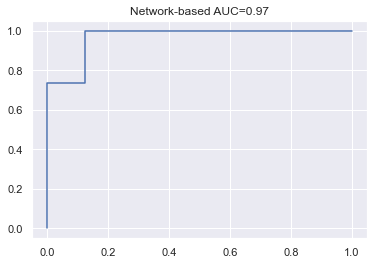

In [364]:
auc_score_cross = metrics.roc_auc_score(cv3_y_train>-1, y_pre_cross)
print(auc_score_cross)

fpr_cross, tpr_cross, thresholds_cross = metrics.roc_curve(cv3_y_train > -1, y_pre_cross)
plt.plot(fpr_cross,tpr_cross)
plt.title('Network-based AUC=%.2f'%(auc_score_cross))
plt.show()

In [365]:
from pandas import DataFrame

y_pre_cv1_sspd = DataFrame(y_pre_cv1_ss,index=test_index_list[0])

y_pre_cv2_sspd = DataFrame(y_pre_cv2_ss,index=test_index_list[1])

y_pre_cv3_sspd = DataFrame(y_pre_cv3_ss,index=test_index_list[2])

y_pre_cv4_sspd = DataFrame(y_pre_cv4_ss,index=test_index_list[3])

y_pre_cv5_sspd = DataFrame(y_pre_cv5_ss,index=test_index_list[4])

Ridge_predss = pd.concat([y_pre_cv1_sspd, y_pre_cv2_sspd, y_pre_cv3_sspd, y_pre_cv4_sspd, y_pre_cv5_sspd],axis=0).sort_index().values.reshape(1,-1)[0]
print(Ridge_predss)

[-0.41503459 -0.48544974  0.46675815 -1.40629193 -0.26066383  0.1507033
 -0.1944396  -1.01050916 -0.86270123 -0.68870172  0.64119241 -0.84922126
  2.24987069  0.94737407  2.99501209 -0.00358543  0.52978088  0.96796221
 -1.88822753  0.45566609  0.62941867 -0.19252259 -1.0044358   0.19541126
  0.27962162  0.23039423  0.46645196 -1.05558269 -0.30635063 -0.28400243
 -0.58884838 -0.12259405  0.80860234  0.93288273  0.56434711  0.81807895
 -0.37044303 -0.23604782 -0.98716318  0.19431152  0.14337071  0.36753128
  1.39555858 -0.02367748 -0.49065103  1.24881904  2.21166659 -0.22907217]


0.7781250000000001


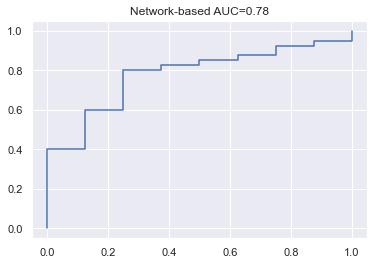

In [366]:
from sklearn import metrics

auc_multi_path = metrics.roc_auc_score(Y>-1, Ridge_predss)
print(auc_multi_path)
fpr, tpr, thresholds = metrics.roc_curve(Y>-1, Ridge_predss)
plt.plot(fpr,tpr)
plt.title('Network-based AUC=%.2f'%(auc_multi_path))
plt.show()

